# **Visit Challenge - Ikea Datafest**

## **0. Introduction and objectives**

The visit challenge presented by Ikea in its first Datafest consists in the forecast of the amount of visits per day of the month of March 2023.

In order to do so, they have given us the visits per day of the last 18 months of two of its main shops (Madrid and Barcelona).

In this way, the structure that we will be following is the next:
1. Libraries used
2. Exploratoration and cleaning of the data
3. Model testing and optimization
4. Conclusion 

Take into account that this process althoug sequential it may retroalimentate itself, that is, we can discover that we need a new data transformation in the model testing and optimization phase.

## **1. Libraries used**

In [1]:
!pip install skforecast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 343.8/343.8 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 6.2 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.65.0
    Uninstalling tqdm-4.65.0:
      Successfully uninstalled tqdm-4.65.0


In [2]:
import numpy as np
import pandas as pd
import utils_visit as ut
from matplotlib import pyplot as plt

from skforecast.model_selection import grid_search_forecaster
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

## **2. Exploratoration and cleaning of the data**

In [3]:
df = pd.read_csv(
    "visits_train.csv", header=0, parse_dates=[1],
    squeeze=True, date_parser=ut.parser
)

df.head()

<ipython-input-3-d020a84434a3>:1: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  df = pd.read_csv(


,location,date_visit,visits
0,Madrid,2023-02-28,67.323720
1,Madrid,2023-02-27,71.894430
2,Madrid,2023-02-26,87.803810
3,Madrid,2023-02-25,90.435243
4,Madrid,2023-02-24,76.281122


In [4]:
df.tail()

,location,date_visit,visits
1333,Barcelona,2021-05-05,43.053853
1334,Barcelona,2021-05-04,44.398808
1335,Barcelona,2021-05-03,47.631696
1336,Barcelona,2021-05-02,25.857399
1337,Barcelona,2021-05-01,0.000000


The first intuiton given that we have data from two stores of different locations is to split the data by this criteria.

### **Barcelona**

In [5]:
df_barcelona = df.loc[df['location'] == 'Barcelona'].drop("location", axis=1).reset_index(drop=True)

df_barcelona.head()

,date_visit,visits
0,2023-02-28,62.664338
1,2023-02-27,62.773327
2,2023-02-26,44.832796
3,2023-02-25,91.033355
4,2023-02-24,65.119594


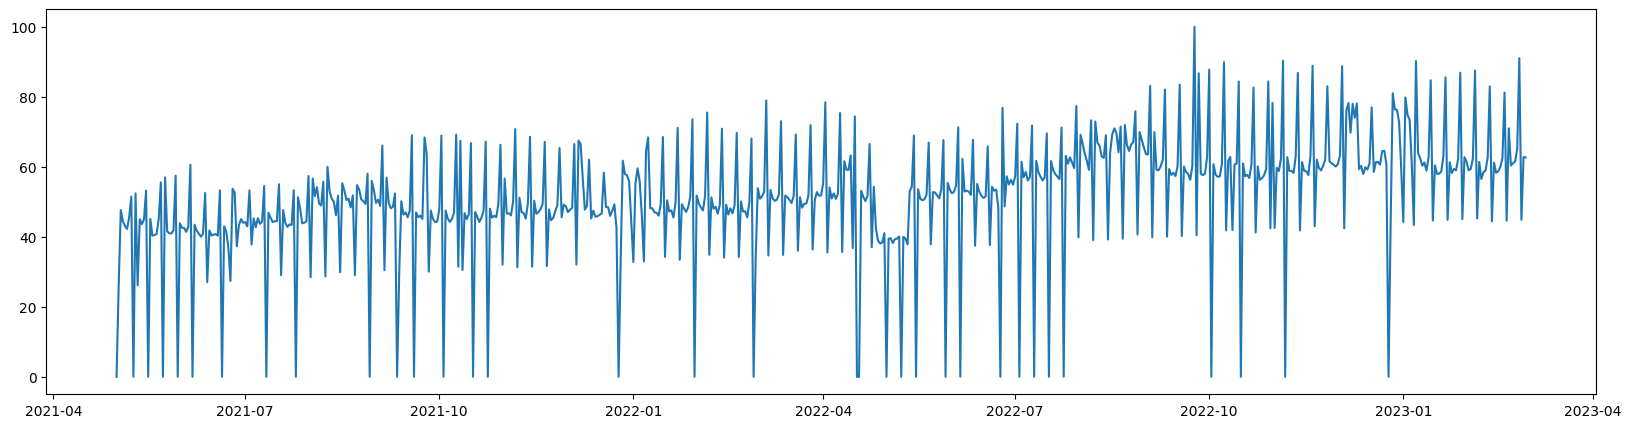

In [6]:
df_barcelona_serie = df_barcelona.set_index('date_visit')

plt.figure(figsize=(20, 5))
plt.plot(df_barcelona_serie)
plt.show()

After ploting the visit distribution of the Barcelona shop, what we can see is that there are many day with 0 visists. Also, we can observe a certain seasonality, let's now plot just a month:

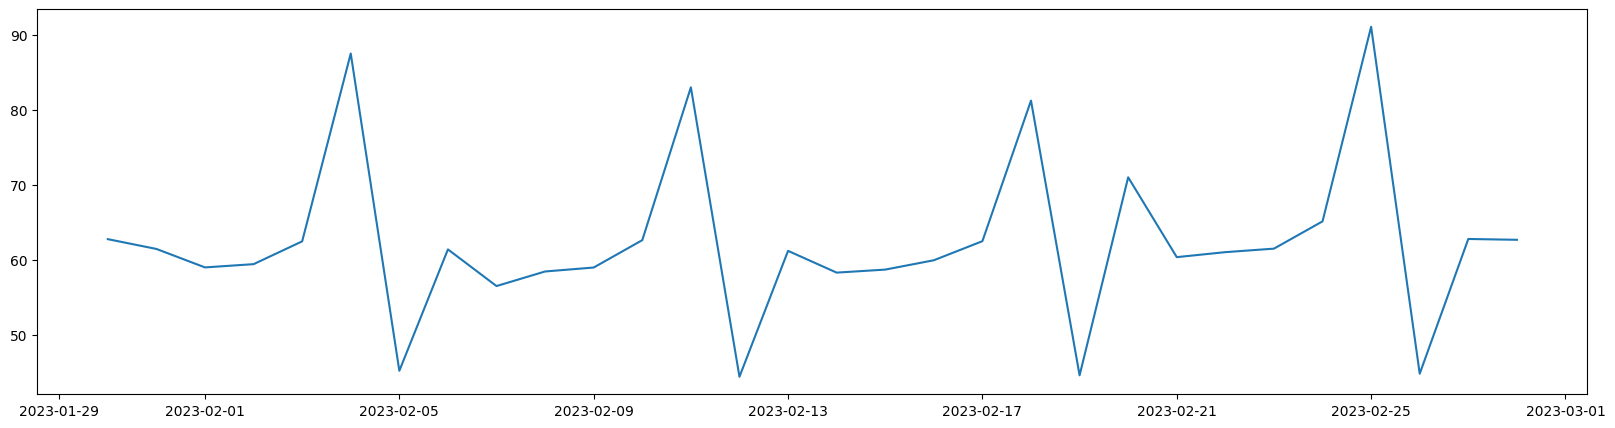

In [7]:
plt.figure(figsize=(20, 5))
plt.plot(df_barcelona_serie[:30])
plt.show()

Now we clearly see a weekly seasonality, so we should decompose the time series with that period:

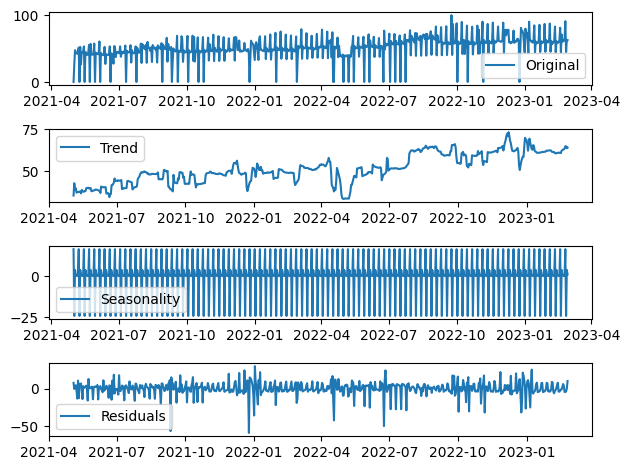

In [8]:
ut.plot_seasonal_decompose(df_barcelona_serie, period=7)

As so, we see a positive trend over time and a constant variance in the seasonality. Therefore, the time series is stacionary, to double check it we will do the Fuller-Dickey test:

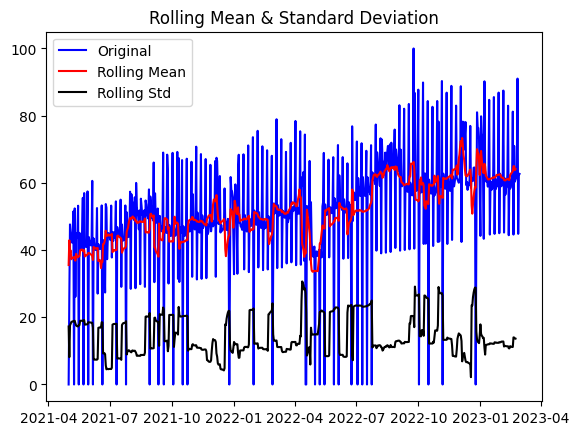

Results of Dickey-Fuller Test:
Test Statistic                  -1.305618
p-value                          0.626598
#Lags Used                      20.000000
Number of Observations Used    648.000000
Critical Value (1%)             -3.440482
Critical Value (5%)             -2.866011
Critical Value (10%)            -2.569151
dtype: float64


In [9]:
ut.test_stationarity(df_barcelona_serie, 7)

The Dickey-Fuller test has as null hypothesis that there is a unit root in the series, which means that the process evolves through time. Since in this case the p-value is 0.62, we have no evidence to reject the null hypothesis. Therefore, the series is non-stationary.

Now, dealing with the zero visit days, what we are going to do (as there is a weekly seasonality) is to substitute that empty value with the average of its correspondent day of the week, that is, if a Monday is missing we will calculate the mean of all Mondays and assign that value.

In [10]:
DICT_BIN = {
    0: 0, 1: 0, 2: 0, 6: 0,
    3: 1, 4: 1, 5: 1,
}

df_barcelona = ut.fill_zeros_with_mean_per_day(df_barcelona)
df_barcelona["Dia_semana"] = df_barcelona["Dia_semana"].map(DICT_BIN)

In [11]:
df_barcelona.head()

,date_visit,visits,Dia_semana
0,2023-02-28,62.664338,0
1,2023-02-27,62.773327,0
2,2023-02-26,44.832796,0
3,2023-02-25,91.033355,1
4,2023-02-24,65.119594,1


Note that we have added a binary column "Dia_semana", as a way to emphatise for the model which days are top in visits (Thursday, Friday and Saturday) and which are not. 

Lastly, we will leave Frebuary 2023 out of the training dataset as a way to test the performance of our model:

In [12]:
FEBRUARY = 28

df_barcelona_train = df_barcelona.iloc[FEBRUARY:]
df_barcelona_train = df_barcelona_train[::-1].reset_index(drop=True)

df_barcelona_test = df_barcelona.iloc[:FEBRUARY]
df_barcelona_test = df_barcelona_test[::-1].reset_index(drop=True)

### **Madrid**

In [13]:
df_madrid = df.loc[df['location'] == 'Madrid'].drop("location", axis=1)

df_madrid.head()

,date_visit,visits
0,2023-02-28,67.323720
1,2023-02-27,71.894430
2,2023-02-26,87.803810
3,2023-02-25,90.435243
4,2023-02-24,76.281122


Now, we will repeat the process done to the Barcelona distribution but for the Madrid store:

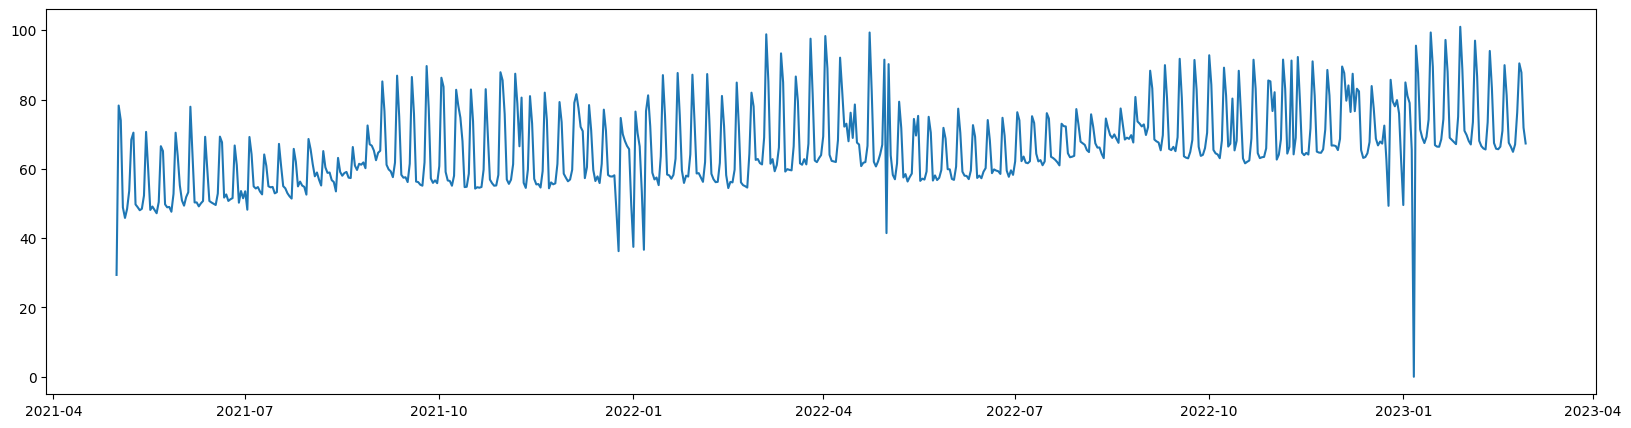

In [14]:
df_madrid_serie = df_madrid.set_index('date_visit')

plt.figure(figsize=(20, 5))
plt.plot(df_madrid_serie)
plt.show()

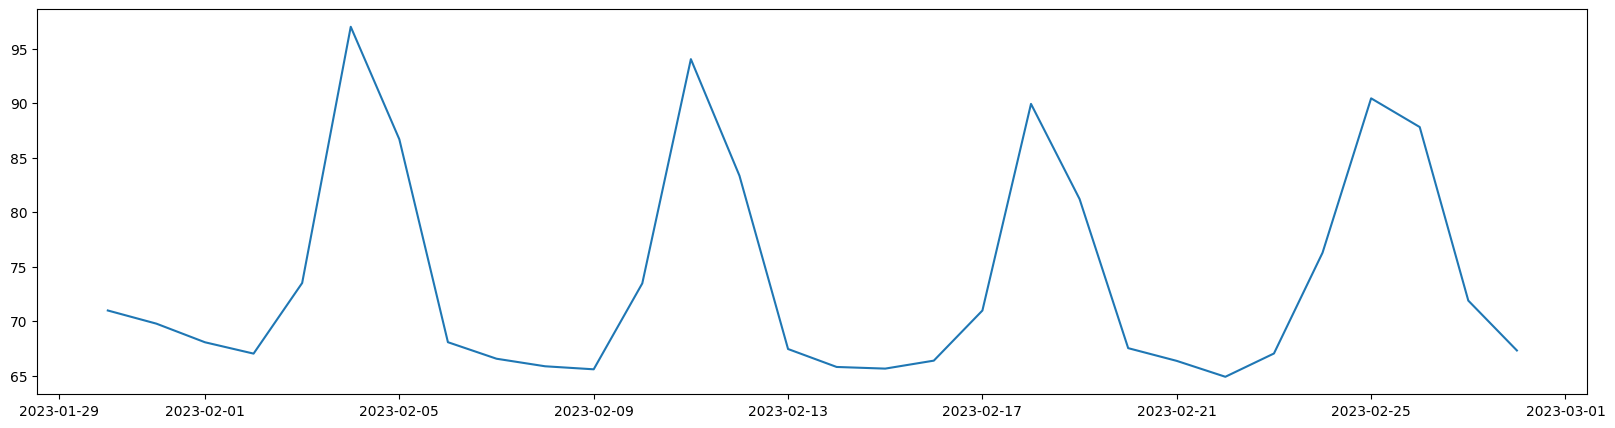

In [15]:
plt.figure(figsize=(20, 5))
plt.plot(df_madrid_serie[:30])
plt.show()

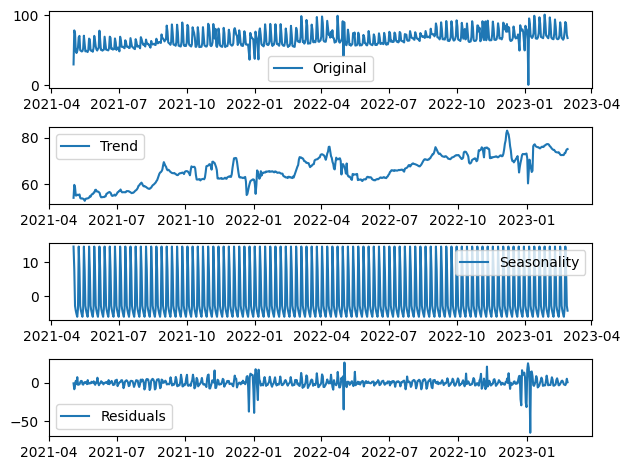

In [16]:
ut.plot_seasonal_decompose(df_madrid_serie, period=7)

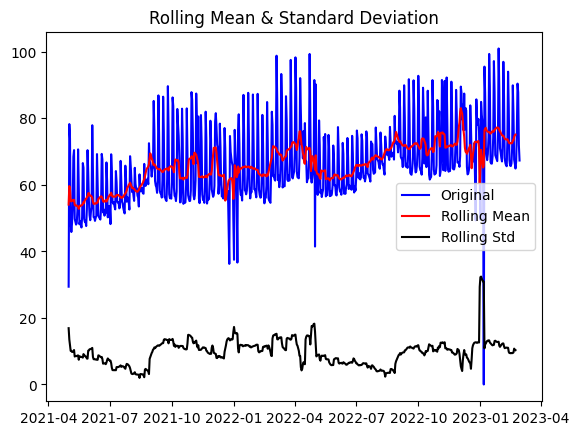

Results of Dickey-Fuller Test:
Test Statistic                  -1.285161
p-value                          0.635934
#Lags Used                      20.000000
Number of Observations Used    648.000000
Critical Value (1%)             -3.440482
Critical Value (5%)             -2.866011
Critical Value (10%)            -2.569151
dtype: float64


In [17]:
ut.test_stationarity(df_madrid_serie, 7)

In [18]:
df_madrid = ut.fill_zeros_with_mean_per_day(df_madrid)
df_madrid["Dia_semana"] = df_madrid["Dia_semana"].map(DICT_BIN)

In [19]:
df_madrid.head()

,date_visit,visits,Dia_semana
0,2023-02-28,67.323720,0
1,2023-02-27,71.894430,0
2,2023-02-26,87.803810,0
3,2023-02-25,90.435243,1
4,2023-02-24,76.281122,1


In [20]:
df_madrid_train = df_madrid.iloc[FEBRUARY:]
df_madrid_train = df_madrid_train[::-1].reset_index(drop=True)

df_madrid_test = df_madrid.iloc[:FEBRUARY]
df_madrid_test = df_madrid_test[::-1].reset_index(drop=True)

## **3. Model testing and optimization**

Although the natural algorithm to use for a time series modelling would be the SARIMAX model, we have found that modelling this particular problem with an autoregresor based on the Gradient Boosting algorithm has a better performance. 

In [21]:
STEPS = 28

LAGS_GRID = [7, 30]
PARAM_GRID = {'n_estimators': [100, 150, 200],
              'max_depth': [3, 5]}

Now we are going to optimize the hyperparameters of the chosen model, which in this case are:
* Amount of lags (a priori should be 7 because of the stationality)
* Amount of trees of the ensemble (n_estimators)
* Maximum depth of every tree (max_depth)

In order to do so, we are using a grid search with refitting, which will allow us to find the best model based on back-testing, that is, testing progressively our model with an increasing amount of training data.

In [22]:
indexes = pd.Series(list(range(641, 669)))
df_barcelona_test = df_barcelona_test.set_index(indexes)
df_madrid_test = df_madrid_test.set_index(indexes)

### **Barcelona**

In [23]:
forecaster_barcelona = ForecasterAutoreg(
    regressor=GradientBoostingRegressor(max_depth=3,
                                        n_estimators=100,
                                        random_state=123),
    lags=7
)

resultados_grid_barcelona = grid_search_forecaster(
    forecaster=forecaster_barcelona,
    y=df_barcelona_train['visits'],
    param_grid=PARAM_GRID,
    lags_grid=LAGS_GRID,
    steps=STEPS,
    refit=True,
    metric='mean_squared_error',
    initial_train_size=int(len(df_barcelona_train) * 0.1),
    fixed_train_size=False,
    return_best=True,
    verbose=False,
    exog=df_barcelona_train["Dia_semana"]
)

Number of models compared: 12.


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [02:36<00:00, 78.39s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7] 
  Parameters: {'max_depth': 3, 'n_estimators': 150}
  Backtesting metric: 63.5612075584681



In [24]:
predicciones_barcelona = forecaster_barcelona.predict(steps=STEPS,
                                                      exog=df_barcelona_test["Dia_semana"])

mse_barcelona = mean_squared_error(
    y_true=np.array(df_barcelona_test["visits"]),
    y_pred=np.array(predicciones_barcelona)
)
rmse_barcelona = np.sqrt(mse_barcelona)

print(f"Root mean squared error: {rmse_barcelona}")

Root mean squared error: 3.4563350806672966


/usr/local/lib/python3.10/dist-packages/skforecast/utils/utils.py:743: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(


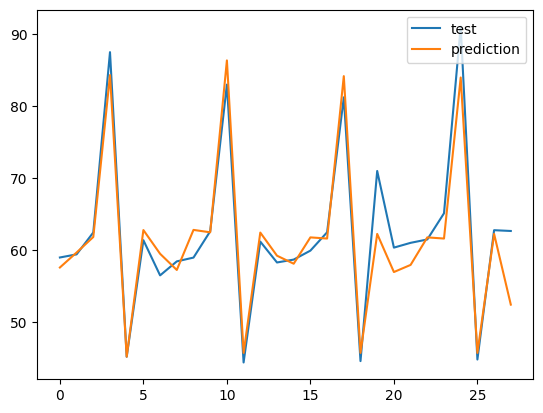

In [25]:
plt.plot(df_barcelona_test['visits'].reset_index(drop=True), label='test')
plt.plot(predicciones_barcelona.reset_index(drop=True), label='prediction')
plt.legend()
plt.show()

### **Madrid**

In [26]:
forecaster_madrid = ForecasterAutoreg(
    regressor=GradientBoostingRegressor(max_depth=3,
                                        n_estimators=100,
                                        random_state=123),
    lags=7
)

resultados_grid_madrid = grid_search_forecaster(
    forecaster=forecaster_madrid,
    y=df_madrid_train['visits'],
    param_grid=PARAM_GRID,
    lags_grid=LAGS_GRID,
    steps=STEPS,
    refit=True,
    metric='mean_squared_error',
    initial_train_size=int(len(df_madrid_train) * 0.1),
    fixed_train_size=False,
    return_best=True,
    verbose=False,
    exog=df_madrid_train["Dia_semana"]
)

Number of models compared: 12.


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [02:35<00:00, 77.58s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7] 
  Parameters: {'max_depth': 5, 'n_estimators': 150}
  Backtesting metric: 57.65816336068925



In [27]:
predicciones_madrid = forecaster_madrid.predict(steps=STEPS,
                                                exog=df_madrid_test["Dia_semana"])

mse_madrid = mean_squared_error(
    y_true=np.array(df_madrid_test["visits"]),
    y_pred=np.array(predicciones_madrid)
)
rmse_madrid = np.sqrt(mse_madrid)

print(f"Root mean squared error: {rmse_madrid}")

Root mean squared error: 3.014792094305963


/usr/local/lib/python3.10/dist-packages/skforecast/utils/utils.py:743: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(


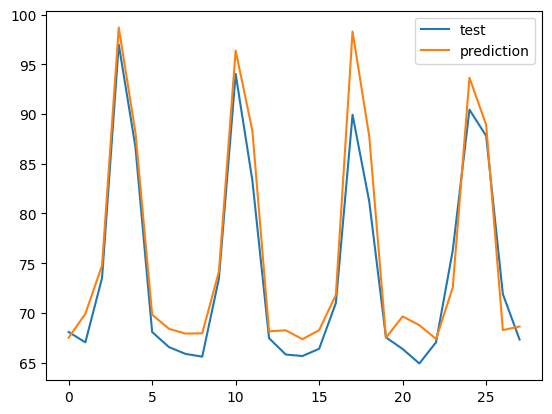

In [28]:
plt.plot(df_madrid_test['visits'].reset_index(drop=True), label='test')
plt.plot(predicciones_madrid.reset_index(drop=True), label='prediction')
plt.legend()
plt.show()

## **4. Conclusion**

As we can see analitycally (RMSE) and graphically our models perform really well. 

So now the last step would be retraining the model with the whole dataset,  forecast March 2023 and submit our results to the Kaggle competition. 